# Script to add endogenous attributes to input data




In [19]:
import os
import pandas as pd

def process_attributes_csv(model_name):
    data_folder = f'../data/{model_name}'  # Go back one level to reach the data folder

    # Ensure the data folder exists
    if not os.path.exists(data_folder):
        print(f"Error: Data folder '{data_folder}' not found.")
        return

    # Function to find 'attributes.csv' in subfolders
    def find_attributes_csv(folder):
        for root, dirs, files in os.walk(folder):
            if 'attributes.csv' in files:
                return os.path.join(root, 'attributes.csv')
        return None

    attributes_csv = find_attributes_csv(data_folder)

    # Check if the 'attributes.csv' file exists in any subfolder
    if attributes_csv is None:
        print(f"Error: 'attributes.csv' not found in any subfolder of '{data_folder}'.")
        return

    # Read the 'attributes.csv' file into a DataFrame
    df = pd.read_csv(attributes_csv)

    # Add the specified lines to the DataFrame
    new_lines = [
        {'num_pwa_segments_default': ',7,'},
        {'learning_rate_default': ',-0.074,'},
        {'global_share_default': '1'},
        {'learning_curve_lower_bound_default': ', 0,'},
        {'learning_curve_upper_bound_default':', 200,'},
        {'learning_curve_npts_default': '1000,'},
        {'global_initial_capacity_default':', 50,'},
    ]

    # Use loc to add new rows to the DataFrame
    for line in new_lines:
        df.loc[len(df)] = line

    # Save the modified DataFrame back to the 'attributes.csv' file, overwriting the original content
    df.to_csv(attributes_csv, index=False)

    print(f"Processed 'attributes.csv' in subfolder: {os.path.dirname(attributes_csv)} and added lines.")

if __name__ == "__main__":
    model_name = "20240118_Hydrogen_vAX/set_technologies"
    process_attributes_csv(model_name)


Processed 'attributes.csv' in subfolder: ../data/20240118_Hydrogen_vAX/set_technologies\set_conversion_technologies\anaerobic_digestion and added lines.


# Option 1: PWA 
This can only do the number of segments that are specified in def piecewise_linear

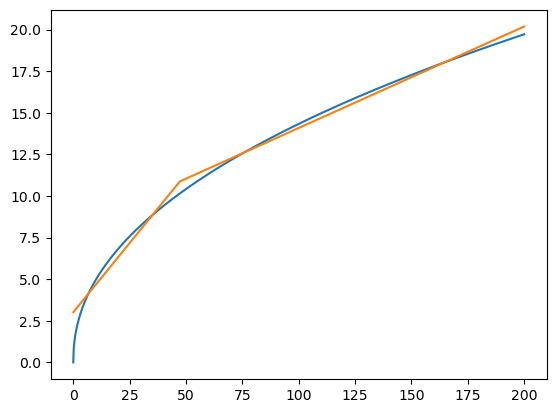

In [5]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

def fun_total_cost(u, c_initial: float, q_initial: float,
                           learning_rate: float) -> object:  # u is a vector
            """
            Total cumulative Cost for Learning Curve
            :param u: Cumulative Capacity
            :param c_initial: Initial Cost
            :param q_initial: Initital Capacity
            :param learning_rate: Learning Rate
            :return: Total cumulative cot
            """
            alpha = c_initial / np.power(q_initial, learning_rate)
            exp = 1 + learning_rate
            TC = alpha / exp * ( np.power(u, exp) )
            return TC

x = np.linspace(0,200, 1000)
c_initial = 1/8760 * 761
q_initial = 60
learning_rate = -0.54
y = fun_total_cost(x, c_initial, q_initial, learning_rate)

p , e = optimize.curve_fit(piecewise_linear, x, y)
plt.plot(x, y)
plt.plot(x, piecewise_linear(x, *p))

# Option 2: PWA with multiple segments



                    Breakpoint Regression Results                     
No. Observations                     1000
No. Model Parameters                    4
Degrees of Freedom                    996
Res. Sum of Squares               116.527
Total Sum of Squares              20191.0
R Squared                        0.994229
Adjusted R Squared               0.994206
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                3.03292       0.0442       68.612           0.0       2.9462       3.1197
alpha1              0.165452      0.00161       102.64           0.0      0.16229      0.16862
beta1              -0.104577      0.00164       -63.91             -     -0.10779     -0.10137
breakpoint1          47.5445        0.486            -             -       46.591       48.498
-----------------

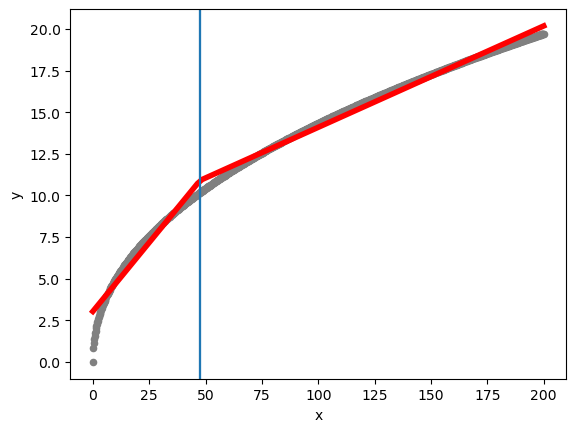

In [8]:
import piecewise_regression
pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=1)
pw_fit.summary()

# Print a summary of the fit
pw_fit.summary()

# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

# Add incremental determination of number of breakpoints

Successful fit with 1 breakpoints.
Successful fit with 2 breakpoints.
Mean squared error is 0.029131245989832286


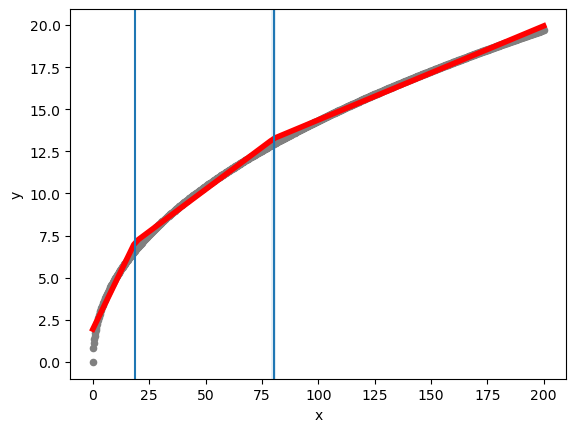

In [43]:
import piecewise_regression

x = np.linspace(0,200, 1000)
c_initial = 1/8760 * 761
q_initial = 60
learning_rate = -0.54
y = fun_total_cost(x, c_initial, q_initial, learning_rate)

n = 1
max_n = 10
while n < max_n:
    pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=n)
    # check if successful fit
    if pw_fit.get_params()["converged"]:
        print(f"Successful fit with {n} breakpoints.")
        x_hat =np.linspace(0, 200, 2000)
        y_hat = pw_fit.predict(x_hat)
        y_true = fun_total_cost(x_hat, c_initial, q_initial, learning_rate)
        mean_sq_error = np.mean(np.power((y_hat - y_true),2))
        if mean_sq_error < 0.05:
            print(f"Mean squared error is {mean_sq_error}")
            break
        else: 
            n += 1
    else:
        print(f"Failed fit with {n} breakpoints.")
        n -= 1
        pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=n)
        break

# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Extract the PWA parameters 

In [157]:
raw_params =  pw_fit.best_muggeo.best_fit.raw_params
breakpoints = pw_fit.best_muggeo.best_fit.next_breakpoints

# Find TC_interpolated
TC_interpolated_first = np.array([raw_params[0]])
TC_interpolated_next = pw_fit.predict(breakpoints)
TC_interpolated= np.concatenate((TC_interpolated_first, TC_interpolated_next))

# Find the y-intersects
tossed_params = raw_params[1:]

# Initialize with the second entry
result = raw_params[1]

# List to store intermediate results
slope = [result]

# Iteratively sum each pair of values in tossed_params with the result from the previous sum
for i in range(0, len(breakpoints)):
    result +=  tossed_params[i + 1]
    slope.append(result)

print(slope)


[0.2761779989592156, 0.09990638532923207, 0.055810576150662414]


In [45]:
pw_fit.get_params()

{'converged': True,
 'const': 1.944553306116025,
 'beta1': -0.1762716136299835,
 'breakpoint1': 18.722167436984574,
 'beta2': -0.04409580917856966,
 'breakpoint2': 80.33072116135969,
 'alpha1': 0.2761779989592156,
 'alpha2': 0.09990638532923207,
 'alpha3': 0.055810576150662414}

In [59]:
pw_fit.best_muggeo.best_fit.residual_sum_squares


30.46838265595618

In [153]:
interpolated_x_first = np.array([x[0]])
interpolated_x_next = breakpoints
interpolated_x = np.concatenate((interpolated_x_first, interpolated_x_next))

In [158]:
intersect = TC_interpolated - slope* interpolated_x

In [159]:
intersect

array([1.94455331, 5.24473997, 8.78698812])

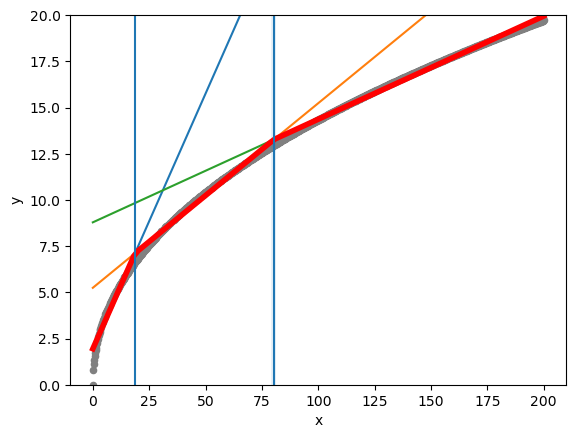

In [169]:
y1 = slope[0]*x + intersect[0]
y2 = slope[1]*x + intersect[1]
y3 = slope[2]*x + intersect[2]

plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)# Pass in standard matplotlib keywords to control any of the plots
# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(0,20)
plt.show()